Import packages

In [93]:
# 引入套件
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import collections
import random
import time
import shap
from tqdm import tqdm

# all_start = time.time()

Read data

In [94]:
# 讀取資料
train_data = pd.read_csv("train.csv")
random.seed(112)
index_0 = random.sample(list(train_data[train_data["is_claim"]==0].index), k=round(54844*(25000/58592)))
index_1 = random.sample(list(train_data[train_data["is_claim"]==1].index), k=round(3748*(25000/58592)))
df = pd.concat([train_data.loc[index_0], train_data.loc[index_1]], join="outer")
y = df["is_claim"]
df = df.drop(["policy_id", "is_claim"], axis=1)
print(df.head(5))

       policy_tenure  age_of_car  age_of_policyholder area_cluster  \
33702       0.134905        0.10             0.288462           C3   
58322       0.683992        0.10             0.384615           C2   
46642       0.440215        0.01             0.480769           C5   
40607       1.196861        0.07             0.442308           C8   
43412       0.041360        0.09             0.423077           C5   

       population_density  make  segment model fuel_type     max_torque  ...  \
33702                4076     3       C2    M4    Diesel  250Nm@2750rpm  ...   
58322               27003     5       C1    M9    Diesel  200Nm@1750rpm  ...   
46642               34738     1        A    M1       CNG   60Nm@3500rpm  ...   
40607                8794     3       C2    M4    Diesel  250Nm@2750rpm  ...   
43412               34738     1  Utility   M10       CNG   85Nm@3000rpm  ...   

      is_rear_window_defogger is_brake_assist  is_power_door_locks  \
33702                     Ye

View type of data

In [95]:
# 檢查資料是否有NA值並刪除id欄位
print(train_data.isna().sum().sum())
print(train_data.shape)
print(train_data.dtypes)

0
(58592, 44)
policy_id                            object
policy_tenure                       float64
age_of_car                          float64
age_of_policyholder                 float64
area_cluster                         object
population_density                    int64
make                                  int64
segment                              object
model                                object
fuel_type                            object
max_torque                           object
max_power                            object
engine_type                          object
airbags                               int64
is_esc                               object
is_adjustable_steering               object
is_tpms                              object
is_parking_sensors                   object
is_parking_camera                    object
rear_brakes_type                     object
displacement                          int64
cylinder                              int64
transmission_type 

Categorical variables

In [96]:
# 觀察類別變數的敘述統計
cat_var = df.select_dtypes("object")
cat_var.describe()

,area_cluster,segment,model,fuel_type,max_torque,max_power,engine_type,is_esc,is_adjustable_steering,is_tpms,...,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert
count,25000,25000,25000,25000,25000,25000,25000,25000,25000,25000,...,25000,25000,25000,25000,25000,25000,25000,25000,25000,25000
unique,22,6,11,3,9,9,11,2,2,2,...,2,2,2,2,2,2,2,2,2,2
top,C8,B2,M1,Petrol,113Nm@4400rpm,88.50bhp@6000rpm,F8D Petrol Engine,No,Yes,No,...,No,No,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes
freq,5927,7902,6308,8803,7675,7675,6308,17099,15291,18976,...,17699,16190,13843,18158,18158,24466,14752,15432,18158,24856


Continuous variables

In [97]:
# 觀察連續變數的敘述統計
conti_var = df.select_dtypes(["int64", "float64"])
conti_var.describe()

,policy_tenure,age_of_car,age_of_policyholder,population_density,make,airbags,displacement,cylinder,gear_box,turning_radius,length,width,height,gross_weight,ncap_rating
count,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.00000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000
mean,0.614572,0.069829,0.469243,18663.264680,1.765960,3.146800,1164.638640,3.633000,5.246720,4.85381,3852.784640,1673.089800,1553.622280,1386.533960,1.763400
std,0.414184,0.056783,0.122309,17473.602889,1.138436,1.838202,265.878998,0.481996,0.431111,0.22814,311.194773,111.973365,79.760182,212.498109,1.388257
min,0.002735,0.000000,0.288462,290.000000,1.000000,1.000000,796.000000,3.000000,5.000000,4.50000,3445.000000,1475.000000,1475.000000,1051.000000,0.000000
25%,0.211151,0.020000,0.375000,6112.000000,1.000000,2.000000,796.000000,3.000000,5.000000,4.60000,3445.000000,1515.000000,1475.000000,1185.000000,0.000000
50%,0.580103,0.060000,0.451923,8794.000000,1.000000,2.000000,1197.000000,4.000000,5.000000,4.80000,3845.000000,1735.000000,1530.000000,1335.000000,2.000000
75%,1.039896,0.110000,0.548077,27003.000000,3.000000,6.000000,1493.000000,4.000000,5.000000,5.00000,3995.000000,1755.000000,1635.000000,1510.000000,3.000000
max,1.375988,1.000000,0.990385,73430.000000,5.000000,6.000000,1498.000000,4.000000,6.000000,5.20000,4300.000000,1811.000000,1825.000000,1720.000000,5.000000


Data Preprocessing

In [98]:
# 定義資料預處理函數
def preprocess(data):
    dt = data.copy()
    cat = dt.select_dtypes("object")
    conti = dt.select_dtypes(["int64", "float64"])
    cat_col = cat.columns
    conti_col = conti.columns
    for col in cat_col:
        num = cat[col].unique()
        if len(num)==2:
            # "Yes"==1且"No"==0
            if "Yes" in num:
                dt[col] = dt[col].map({"Yes": 1, "No": 0})
            # 無順序之類別則用one hot encoding來轉換
            elif "Drum" in num:
                dt["is_Drum"] = dt[col].map({"Drum": 1, "Disc": 0})
                dt["is_Disc"] = dt[col].map({"Disc": 1, "Drum": 0})
                dt = dt.drop(col, axis=1)
            # 無順序之類別則用one hot encoding來轉換
            else:
                dt["is_Manual"] = dt[col].map({"Manual": 1, "Automatic": 0})
                dt["is_Automatic"] = dt[col].map({"Automatic": 1, "Manual": 0})
                dt = dt.drop(col, axis=1)
        elif len(num)==3:
            # 無順序之類別則用one hot encoding來轉換
            if col=="fuel_type":
                dt["is_CNG"] = dt[col].map({"CNG": 1, "Petrol": 0, "Diesel": 0})
                dt["is_Petrol"] = dt[col].map({"Petrol": 1, "CNG": 0, "Diesel": 0})
                dt = dt.drop(col, axis=1)
            # 無順序之類別則用one hot encoding來轉換
            else:
                dt["is_Power"] = dt[col].map({"Power": 1, "Electric": 0, "Manual": 0})
                dt["is_Electric"] = dt[col].map({"Electric": 1, "Power": 0, "Manual": 0})
                dt = dt.drop(col, axis=1)
        else:
            # 取出扭力值
            if col=="max_torque":
                dic = {}
                for n in num:
                    dic.update({n: float(re.findall(r"-?\d+\.?\d*", n)[0])})
                dt[col] = dt[col].map(dic)
                max = dt[col].max()
                min = dt[col].min()
                dt[col] = (dt[col]-min)/(max-min)
            # 取出馬力值
            elif col=="max_power":
                dic = {}
                for n in num:
                    dic.update({n: float(re.findall(r"-?\d+\.?\d*", n)[0])})
                dt[col] = dt[col].map(dic)
                max = dt[col].max()
                min = dt[col].min()
                dt[col] = (dt[col]-min)/(max-min)
            # 其餘變數皆使用frequency encoding來轉換並標準化
            else:
                c = collections.Counter(dt[col])
                dt[col] = dt[col].map(c)
                max = dt[col].max()
                min = dt[col].min()
                dt[col] = (dt[col]-min)/(max-min)
                
    # 對所有連續變數標準化
    for col in conti_col:
        max = dt[col].max()
        min = dt[col].min()
        dt[col] = (dt[col]-min)/(max-min)
       
    return dt



Useful Tool

In [99]:
# 定義分割資料函數
def split_data(df, y, test_proportion, random_state):
    size = df.shape[0]
    partition = int(size*test_proportion)
    order = np.array(df.index)
    random.seed(random_state)
    random.shuffle(order)
    train_idx = order[partition:]
    test_idx = order[:partition]
    train_x, test_x = df.loc[train_idx], df.loc[test_idx]
    train_y, test_y = y.loc[train_idx], y.loc[test_idx]
    return train_x, test_x, train_y, test_y

Split data

In [100]:
# 將資料分割成訓練集與測試集
x_train, x_test, y_train, y_test = split_data(df, y, test_proportion=0.2, random_state=1121117)
x_train = preprocess(x_train)
x_test = preprocess(x_test)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((20000, 46), (5000, 46), (20000,), (5000,))

New feature set

In [101]:
# 透過cramer's V以及pearson等相關性檢定的結果來看特徵之間的相關性，再將相關性最高的幾個特徵相乘當作交互作用項納入新特徵集中去觀察是否新特徵集有優於原特徵集的跡象
x_train_new = x_train.copy()
x_test_new = x_test.copy()
x_train_new["new_cat_feature"] = x_train_new["model"]*x_train_new["is_speed_alert"]
x_test_new["new_cat_feature"] = x_test_new["model"]*x_test_new["is_speed_alert"]
x_train_new["new_conti_feature"] = x_train_new["displacement"]*x_train_new["length"]*x_train_new["turning_radius"]*x_train_new["width"]
x_test_new["new_conti_feature"] = x_test_new["displacement"]*x_test_new["length"]*x_test_new["turning_radius"]*x_test_new["width"]
x_train_new.shape, x_test_new.shape

((20000, 48), (5000, 48))

Basic Linear Classifier

In [102]:
class classifier:
    def __init__(self, learning_rate=0.005, max_iter=100):
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        
    # 定義線性分類器函數
    def linearclassfier(self, df, label):
        
        label = label.map({0: -1})
        # 樣本數以及特徵數
        order = np.array(df.index)
        n = df.shape[0]
        len_ft = df.shape[1]
        
        # 隨機給定參數初始值
        random.seed(123)
        w = np.random.rand(len_ft)
        b = np.random.random()

        iter = correct_positive_num = 0
        start = time.time()
        # 設定迭代停止條件
        while iter < self.max_iter or correct_positive_num != len(label):
            iter += 1
            neg_predict_num = correct_positive_num = 0
            random.shuffle(order)
            for idx in order:
                x = np.array(df.loc[idx], dtype="float")
                # 依照預測數值正負號判定是哪類
                y_hat = 1 if (np.dot(w, x)+b) > 0 else -1
                # 若分類錯誤(label*預測結果小於零)，則進入迭代更新;若分類正確，則正確預測數加一
                if label[idx]*y_hat <= 0:
                    for j in range(len(w)):
                        w[j] += self.learning_rate*(x[j]*label[idx])
                    b += label[idx]
                else:
                    correct_positive_num += 1
                # 若預測結果與測試資料不相符，則不正確預測數加一
                neg_predict_num += 1 if label[idx]!=y_hat else 0
        # 計算loss=不正確預測數除總數
        loss = neg_predict_num/n
        end = time.time()
        print("迭代次數：%f 次" % iter)
        print("執行時間：%f 秒" % (end-start))
        self.w = w
        self.b = b
        return self.w, self.b, iter, loss
    
    
    # 定義預測函數
    def predict(self, df, label):
        p = label.copy()
        order = label.index
        correct = 0
        for i in order:
            x = np.array(df.loc[i], dtype="float")
            y = np.dot(self.w, x)+self.b
            y_hat = 1 if y > 0 else 0
            p[i] = y_hat
            correct += 1 if label[i]==y_hat else 0     
        acc = correct/len(label)
        self.acc = acc
        # print("準確度：%f" % acc)
        return p, acc
    
    # 定義loss函數
    def loss(self, label, prediction):
        loss = 0
        length = len(label)
        order = np.array(label.index)
        for i in order:
            loss += 1 if label[i]!=prediction[i] else 0
        return loss/length

    # 定義交叉驗證函數
    def kfold(self, df, y, test, test_label, k):
        size = df.shape[0]
        fold = size//k
        order = np.array(df.index)
        error = train_error = 0
        train_loss = []
        valid_loss = []
        random.shuffle(order)
        for i in range(k):
            # 將資料分割成k等分
            test_idx = order[i*fold:(i+1)*fold]
            train_idx = np.concatenate([order[:i*fold], order[(i+1)*fold:]])
            
            train_x, test_x = df.loc[train_idx], df.loc[test_idx]
            train_y, test_y = y[train_idx], y[test_idx]
            print("第%f次計算" % (i+1))

            # 訓練模型
            train = self.linearclassfier(train_x, train_y)

            # 預測結果
            valid_pred = self.predict(test_x, test_y)
            test_pred = self.predict(test, test_label)
            print("測試集準確率：%f" % test_pred[1])
            # 計算loss
            valid_loss.append(self.loss(test_y, valid_pred[0]))
            train_loss.append(train[3])
            error += self.loss(test_y, valid_pred[0])
            train_error += train[3]
        print("驗證平均誤差：%f" % (error/k))
        return train_error/k, error/k, train_loss, valid_loss
    
    def predict_proba(self, df):
        order = len(df)
        proba = []
        for i in range(order):
            x = np.array(df[i], dtype="float")
            y = np.dot(self.w, x) + self.b
            sigmoid = 1/(1 + np.exp(-y))
            if y > 0:
                proba.append([sigmoid, 1-sigmoid])
            else:
                proba.append([1-sigmoid, sigmoid])
        return np.array(proba)

    def feature_importance(self, df, y, predict_times):
        diff = {}
        accuracy = self.acc
        start = time.time()
        for col in tqdm(df.columns):
            X = df.copy()
            p = 0
            for _ in range(predict_times):
                # 因為隨機排序每次跑的結果都不同，因此重複隨機k次取平均來取代準確率分數
                X[col] = np.random.permutation(X[col])
                pred = self.predict(X, y)
                p += pred[1]

            # 計算與原始資料的準確率差異
            diff[col] = (10**8)*(abs(accuracy-p/predict_times)) # 乘上10的6次方是為了放大差異(因為差異值介在0到1之間)
        print("執行時間：%f 秒" % (time.time()-start))
        return diff

Training and predicting result

In [103]:
# 訓練線性分類器模型
lcf = classifier()
lcfmodel = lcf.linearclassfier(x_train, y_train)
pred = lcf.predict(x_test, y_test)
pred[1]

迭代次數：100.000000 次
執行時間：68.660674 秒


0.9324

Feature Importance for Linear classifier

In [104]:
# 使用排序重要性方法來找出重要特徵（參考：https://www.kaggle.com/code/dansbecker/permutation-importance/tutorial?utm_medium=email&utm_source=mailchimp&utm_campaign=ml4insights）
importance = lcf.feature_importance(df=x_test, y=y_test, predict_times=100)
fi = [importance[col] for col in x_test.columns]
m = max(fi)
n = min(fi)
fi = [(fi[i]-n)/(m-n) for i in range(len(fi))] # 標準化
faeture_importance = pd.DataFrame(x_test.columns)
faeture_importance["scores"] = fi
faeture_importance.columns = ["colname", "accuracy error"]
faeture_importance.sort_values(by="accuracy error", ascending=False)[:20]

100%|██████████| 46/46 [10:07<00:00, 13.21s/it]

執行時間：607.637253 秒


,colname,accuracy error
40,is_Drum,1.000000
38,is_CNG,0.744672
39,is_Petrol,0.337336
45,is_Electric,0.117428
4,population_density,0.044966
5,make,0.015069
19,gear_box,0.013988
2,age_of_policyholder,0.013988
1,age_of_car,0.013928
24,gross_weight,0.013688


  0%|          | 0/5000 [00:00<?, ?it/s]

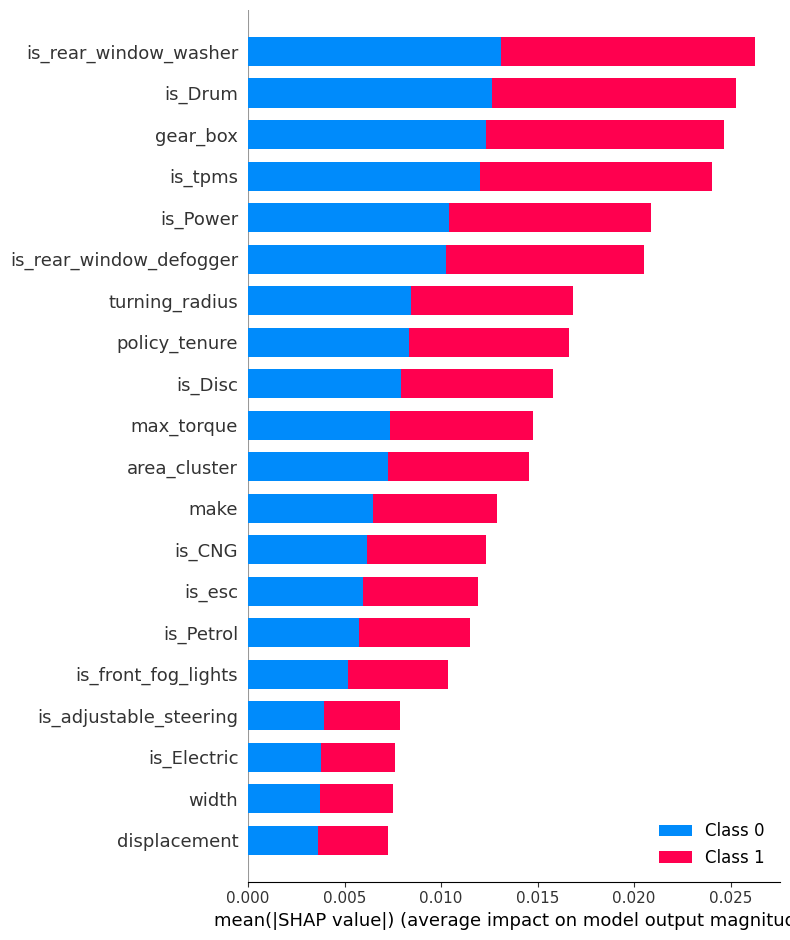

In [112]:
# 使用 KernelExplainer 套用自己的模型來計算 SHAP 值
lcf_explainer = shap.KernelExplainer(lcf.predict_proba, np.array(shap.sample(x_train, 100), dtype="float")).shap_values(np.array(x_test, dtype="float"))

# 顯示 SHAP 摘要圖
shap.summary_plot(lcf_explainer, np.array(x_test, dtype="float"), feature_names=x_test.columns)

Using SHAP and sklearn package to observe feature importance for linear classifier

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


  0%|          | 0/5000 [00:00<?, ?it/s]

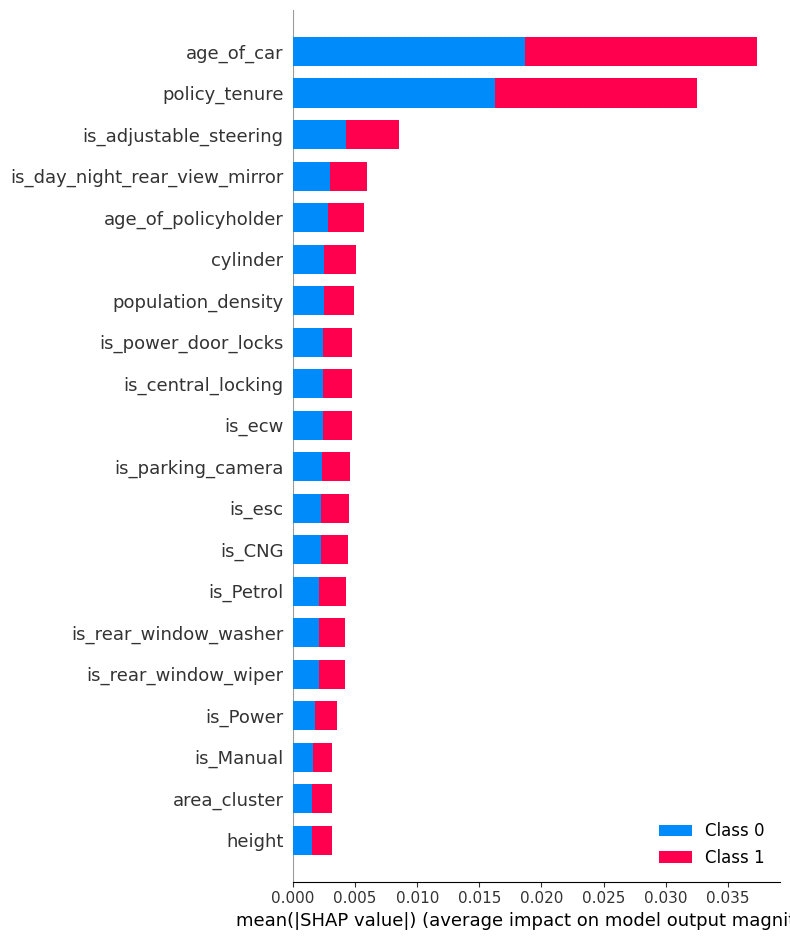

In [113]:
from sklearn.linear_model import LogisticRegression

# 創建一個線性分類器
linear = LogisticRegression()
linear.fit(x_train, y_train)

# 使用 KernelExplainer 計算 SHAP 值
lcf_explainer = shap.KernelExplainer(linear.predict_proba, shap.sample(x_train, 100)).shap_values(x_test)

# 顯示 SHAP 摘要圖
shap.summary_plot(lcf_explainer, x_test)

Linear classifier by k-fold cross validation

In [86]:
cv3 = lcf.kfold(x_train, y_train, x_test, y_test, k=3)

第1.000000次計算
迭代次數：100.000000 次
執行時間：49.580110 秒
測試集準確率：0.933000
第2.000000次計算
迭代次數：100.000000 次
執行時間：47.177714 秒
測試集準確率：0.930800
第3.000000次計算
迭代次數：100.000000 次
執行時間：45.361604 秒
測試集準確率：0.933000
驗證平均誤差：0.063206


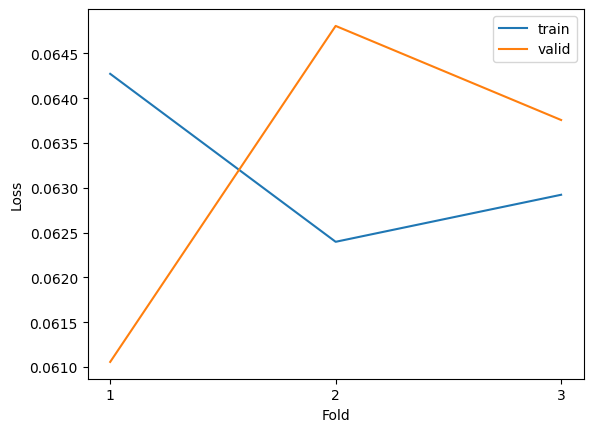

In [87]:
# k = 3
x3 = range(1, 4)
plt.plot(x3, cv3[2], '-', label="train")
plt.plot(x3, cv3[3], '-', label="valid")
plt.xticks(ticks=x3, labels=x3)
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.legend(loc='best')

In [88]:
cv5 = lcf.kfold(x_train, y_train, x_test, y_test, k=5)

第1.000000次計算
迭代次數：100.000000 次
執行時間：58.814898 秒
測試集準確率：0.933000
第2.000000次計算
迭代次數：100.000000 次
執行時間：55.851575 秒
測試集準確率：0.933000
第3.000000次計算
迭代次數：100.000000 次
執行時間：57.518819 秒
測試集準確率：0.933000
第4.000000次計算
迭代次數：100.000000 次
執行時間：54.970811 秒
測試集準確率：0.933000
第5.000000次計算
迭代次數：100.000000 次
執行時間：56.579133 秒
測試集準確率：0.933000
驗證平均誤差：0.063200


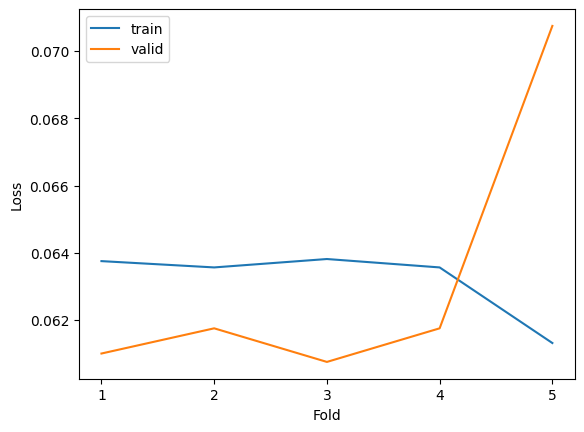

In [89]:
# k = 5
x5 = range(1, 6)
plt.plot(x5, cv5[2], '-', label="train")
plt.plot(x5, cv5[3], '-', label="valid")
plt.xticks(ticks=x5, labels=x5)
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.legend(loc='best')

In [90]:
cv10 = lcf.kfold(x_train, y_train, x_test, y_test, k=10)

第1.000000次計算
迭代次數：100.000000 次
執行時間：64.408287 秒
測試集準確率：0.933000
第2.000000次計算
迭代次數：100.000000 次
執行時間：63.336466 秒
測試集準確率：0.933000
第3.000000次計算
迭代次數：100.000000 次
執行時間：63.993712 秒
測試集準確率：0.932600
第4.000000次計算
迭代次數：100.000000 次
執行時間：62.617754 秒
測試集準確率：0.932600
第5.000000次計算
迭代次數：100.000000 次
執行時間：63.368020 秒
測試集準確率：0.933000
第6.000000次計算
迭代次數：100.000000 次
執行時間：62.507377 秒
測試集準確率：0.933000
第7.000000次計算
迭代次數：100.000000 次
執行時間：62.569735 秒
測試集準確率：0.933000
第8.000000次計算
迭代次數：100.000000 次
執行時間：62.264222 秒
測試集準確率：0.933000
第9.000000次計算
迭代次數：100.000000 次
執行時間：61.956790 秒
測試集準確率：0.932600
第10.000000次計算
迭代次數：100.000000 次
執行時間：61.496863 秒
測試集準確率：0.932000
驗證平均誤差：0.063200


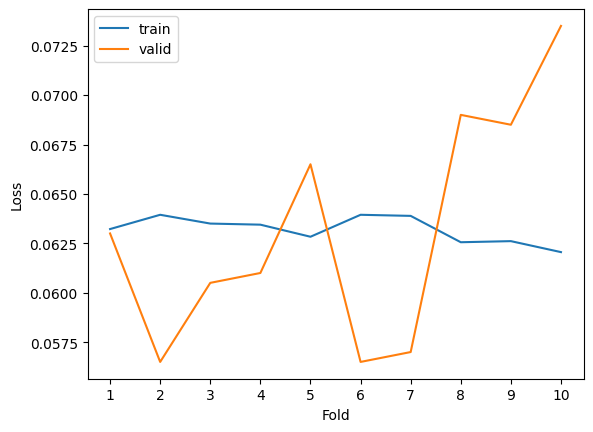

In [91]:
# k = 10
x10 = range(1, 11)
plt.plot(x10, cv10[2], '-', label="train")
plt.plot(x10, cv10[3], '-', label="valid")
plt.xticks(ticks=x10, labels=x10)
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.legend(loc='best')

Using 5-fold cross validation to Check if new feature set is better than oiginal feature set for linear classifier

In [92]:
new_cv5 = lcf.kfold(x_train_new, y_train, x_test_new, y_test, k=5)

第1.000000次計算
迭代次數：100.000000 次
執行時間：39.996840 秒
測試集準確率：0.932800
第2.000000次計算
迭代次數：100.000000 次
執行時間：39.646496 秒
測試集準確率：0.932600
第3.000000次計算
迭代次數：100.000000 次
執行時間：40.227976 秒
測試集準確率：0.933000
第4.000000次計算
迭代次數：100.000000 次
執行時間：39.991587 秒
測試集準確率：0.932200
第5.000000次計算
迭代次數：100.000000 次
執行時間：40.341579 秒
測試集準確率：0.933000
驗證平均誤差：0.063200


K Nearest Neighbor Classifier

In [32]:
from multiprocessing import Pool
from multiprocessing import cpu_count
import knnclassifier as knn # 引入knnclassifier.py
from functools import partial
cpus_num = cpu_count()
print(cpus_num)
test_data = x_test.values.tolist()
core = 5

10


KNN result with difference distances

In [33]:
# p = 1, 2, 3
func1 = partial(knn.knnclassifier, train = x_train, train_label = y_train, knn = 101, p = 1)
func2 = partial(knn.knnclassifier, train = x_train, train_label = y_train, knn = 101, p = 2)
func3 = partial(knn.knnclassifier, train = x_train, train_label = y_train, knn = 101, p = 3)
with Pool(processes = core) as pool:
    prediction_1 = list(tqdm(pool.imap(func1, test_data), total = len(test_data)))
    prediction_2 = list(tqdm(pool.imap(func2, test_data), total = len(test_data)))
    prediction_3 = list(tqdm(pool.imap(func3, test_data), total = len(test_data)))

100%|██████████| 5000/5000 [11:16<00:00,  7.39it/s]


In [34]:
print("準確率：%f(p=1)" % knn.predict(pred = prediction_1, label = y_test))
print("準確率：%f(p=2)" % knn.predict(pred = prediction_2, label = y_test))
print("準確率：%f(p=3)" % knn.predict(pred = prediction_3, label = y_test))

準確率：0.933000(p=1)
準確率：0.933000(p=2)
準確率：0.933000(p=3)


KNN by k-folds cross validation

In [35]:
# k = 3
knncv3 = knn.kfold(train=x_train, train_label=y_train, test=x_test, test_label=y_test, k=3, knn=101, p=1, cpus=core)

第1.000000次計算


100%|██████████| 5000/5000 [07:25<00:00, 11.22it/s]


測試集準確率：0.933000
第2.000000次計算


100%|██████████| 5000/5000 [07:31<00:00, 11.07it/s]


測試集準確率：0.933000
第3.000000次計算


100%|██████████| 5000/5000 [07:29<00:00, 11.13it/s]


測試集準確率：0.933000
驗證平均誤差：0.063206
運行時間：3139.529344 秒


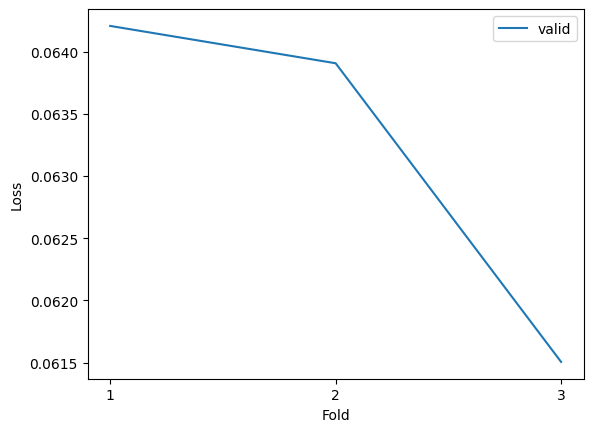

In [41]:
# k = 3
x3 = range(1, 4)
plt.plot(x3, knncv3[3], '-', label="valid")
plt.xticks(ticks=x3, labels=x3)
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.legend(loc='best')

In [44]:
# k = 5
knncv5 = knn.kfold(train=x_train, train_label=y_train, test=x_test, test_label=y_test, k=5, knn=101, p=1, cpus=core)

第1.000000次計算


100%|██████████| 5000/5000 [08:56<00:00,  9.33it/s]

測試集準確率：0.933000
第2.000000次計算



100%|██████████| 5000/5000 [08:58<00:00,  9.28it/s]

測試集準確率：0.933000
第3.000000次計算



100%|██████████| 5000/5000 [09:00<00:00,  9.25it/s]

測試集準確率：0.933000
第4.000000次計算



100%|██████████| 5000/5000 [08:57<00:00,  9.31it/s]

測試集準確率：0.933000
第5.000000次計算



100%|██████████| 5000/5000 [08:57<00:00,  9.30it/s]

測試集準確率：0.933000
驗證平均誤差：0.063200
運行時間：4842.316424 秒


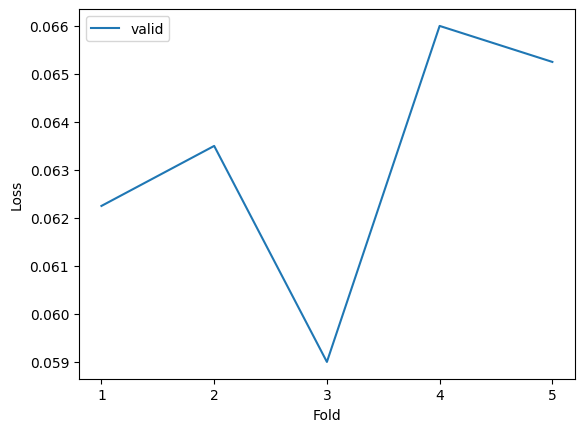

In [45]:
# k = 5
x5 = range(1, 6)
plt.plot(x5, knncv5[3], '-', label="valid")
plt.xticks(ticks=x5, labels=x5)
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.legend(loc='best')

In [46]:
# k = 10
knncv10 = knn.kfold(train=x_train, train_label=y_train, test=x_test, test_label=y_test, k=10, knn=101, p=1, cpus=core)

第1.000000次計算


100%|██████████| 5000/5000 [10:07<00:00,  8.24it/s]

測試集準確率：0.933000
第2.000000次計算



100%|██████████| 5000/5000 [10:07<00:00,  8.24it/s]

測試集準確率：0.933000
第3.000000次計算



100%|██████████| 5000/5000 [10:04<00:00,  8.27it/s]

測試集準確率：0.933000
第4.000000次計算



100%|██████████| 5000/5000 [10:03<00:00,  8.28it/s]

測試集準確率：0.933000
第5.000000次計算



100%|██████████| 5000/5000 [10:06<00:00,  8.24it/s]

測試集準確率：0.933000
第6.000000次計算



100%|██████████| 5000/5000 [10:03<00:00,  8.29it/s]

測試集準確率：0.933000
第7.000000次計算



100%|██████████| 5000/5000 [10:01<00:00,  8.31it/s]

測試集準確率：0.933000
第8.000000次計算



100%|██████████| 5000/5000 [10:03<00:00,  8.29it/s]

測試集準確率：0.933000
第9.000000次計算



100%|██████████| 5000/5000 [10:06<00:00,  8.24it/s]

測試集準確率：0.933000
第10.000000次計算



100%|██████████| 5000/5000 [10:05<00:00,  8.26it/s]

測試集準確率：0.933000
驗證平均誤差：0.063200
運行時間：8467.131182 秒


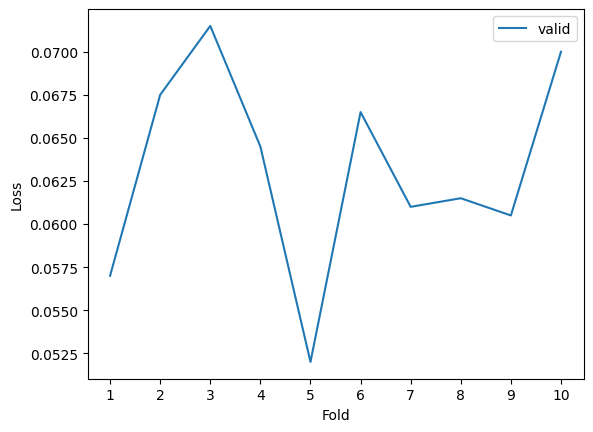

In [47]:
# k = 10
x10 = range(1, 11)
plt.plot(x10, knncv10[3], '-', label="valid")
plt.xticks(ticks=x10, labels=x10)
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.legend(loc='best')

Basic Decision Tree Classifier

In [114]:
from decisiontree import DecitionTree # 引入decisiontree.py
dt = DecitionTree()
# 將特徵與label合併
x_train["is_claim"] = y_train
x_test["is_claim"] = y_test
x_train_new["is_claim"] = y_train
x_test_new["is_claim"] = y_test

Training and predicting result

In [49]:
# 訓練決策樹模型
start = time.time()
tree = dt.fit(df=x_train, max_depth=None)
p = dt.make_predictions(x_test, tree)
print("執行時間：%f 秒" % (time.time()-start))
print("準確率：%f" % p[1])

執行時間：66.126340 秒
準確率：0.843400


Feature Importance for Basic decision tree

In [50]:
# 使用排序重要性方法來找出重要特徵（參考：https://www.kaggle.com/code/dansbecker/permutation-importance/tutorial?utm_medium=email&utm_source=mailchimp&utm_campaign=ml4insights）
dt_importance = dt.feature_importance(df=x_test, predict_times=100)
dt_fi = [dt_importance[col] for col in x_test.columns[:-1]]
m = max(dt_fi)
n = min(dt_fi)
dt_fi = [(dt_fi[i]-n)/(m-n) for i in range(len(dt_fi))] # 標準化
dt_faeture_importance = pd.DataFrame(x_test.columns[:-1])
dt_faeture_importance["sores"] = dt_fi
dt_faeture_importance.columns = ["colname", "accuracy error"]
dt_faeture_importance.sort_values(by="accuracy error", ascending=False)[:20]

100%|██████████| 46/46 [07:20<00:00,  9.58s/it]

執行時間：440.694163 秒


,colname,accuracy error
0,policy_tenure,1.000000
1,age_of_car,0.913289
13,is_adjustable_steering,0.660771
2,age_of_policyholder,0.482928
24,gross_weight,0.452960
43,is_Automatic,0.312700
37,ncap_rating,0.187423
4,population_density,0.093834
39,is_Petrol,0.072709
18,cylinder,0.061164


Using SHAP and sklearn package to observe feature importance for basic decision tree

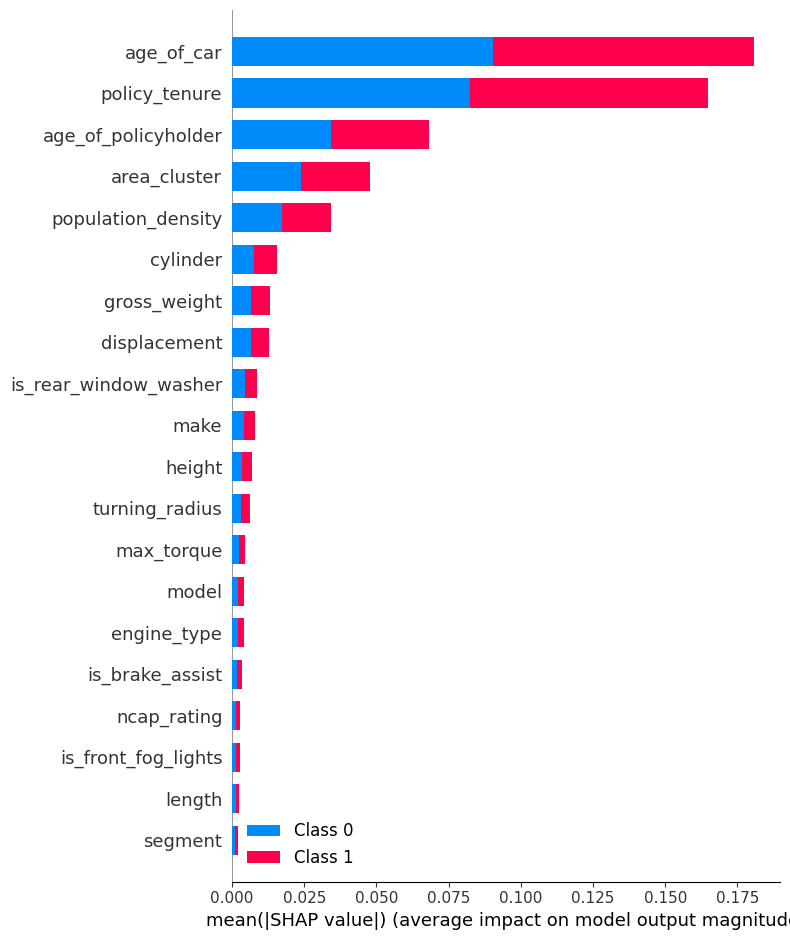

In [52]:
from sklearn.tree import DecisionTreeClassifier

# 創建一個決策樹分類器
tree_package = DecisionTreeClassifier()
tree_package.fit(x_train.drop("is_claim", axis=1), y_train)
tree_explainer = shap.TreeExplainer(tree_package).shap_values(x_test.drop("is_claim", axis=1))

# 顯示 SHAP 摘要圖
shap.summary_plot(tree_explainer, x_test.drop("is_claim", axis=1))

Decision tree by k-fold cross validation

第1.000000次計算
第2.000000次計算
第3.000000次計算
驗證平均誤差：0.125213
運行時間：108.699713 秒


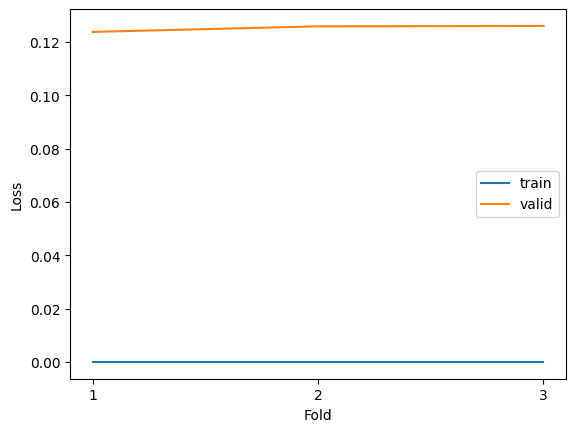

In [53]:
# k = 3
dtcv3 = dt.kfold(max_depth=None, df=x_train, test=x_test, k=3)
plt.plot(x3, dtcv3[2], '-', label="train")
plt.plot(x3, dtcv3[3], '-', label="valid")
plt.xticks(ticks=x3, labels=x3)
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.legend(loc='best')

第1.000000次計算
第2.000000次計算
第3.000000次計算
第4.000000次計算
第5.000000次計算
測試集準確率：0.885800
驗證平均誤差：0.125600
運行時間：243.924423 秒


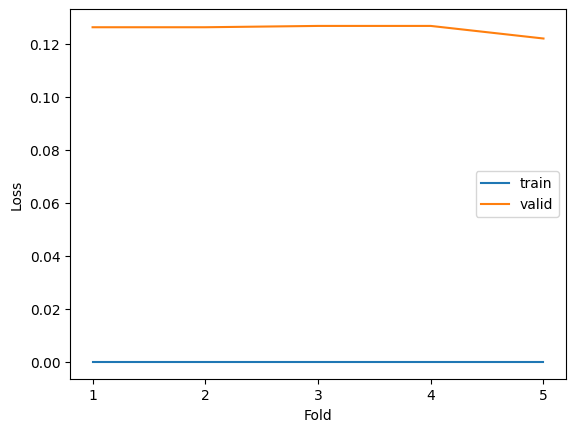

In [54]:
# k = 5；回傳預測結果(3.2結果：交叉驗證預測依照投票決定結果比單一分類模型的準確率更高)
dtcv5 = dt.kfold(max_depth=None, df=x_train, test=x_test, k=5, return_result=True)
plt.plot(x5, dtcv5[2], '-', label="train")
plt.plot(x5, dtcv5[3], '-', label="valid")
plt.xticks(ticks=x5, labels=x5)
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.legend(loc='best')

第1.000000次計算
第2.000000次計算
第3.000000次計算
第4.000000次計算
第5.000000次計算
第6.000000次計算
第7.000000次計算
第8.000000次計算
第9.000000次計算
第10.000000次計算
驗證平均誤差：0.123000
運行時間：561.309766 秒


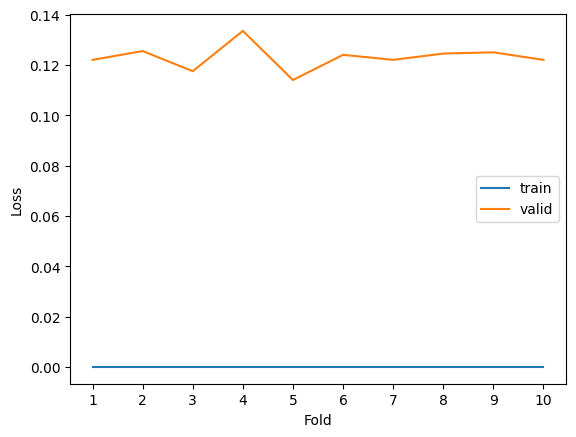

In [55]:
# k = 10
dtcv10 = dt.kfold(max_depth=None, df=x_train, test=x_test, k=10)
plt.plot(x10, dtcv10[2], '-', label="train")
plt.plot(x10, dtcv10[3], '-', label="valid")
plt.xticks(ticks=x10, labels=x10)
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.legend(loc='best')

Using 5-fold cross validation to Check if new feature set is better than oiginal feature set for basic decision tree

In [56]:
new_dtcv5 = dt.kfold(max_depth=None, df=x_train_new, test=x_test_new, k=5)

第1.000000次計算
第2.000000次計算
第3.000000次計算
第4.000000次計算
第5.000000次計算
驗證平均誤差：0.125300
運行時間：243.340565 秒


Decision Tree Classifier with pre-pruning

In [ ]:
# 使用交叉驗證(k=5)來找尋預剪枝的最佳深度
func = partial(dt.kfold, df=x_train, test=x_test, k=5)
with Pool(processes = core) as pool:
    tree_prun = list(tqdm(pool.imap(func, list(range(1, 21))), total = 20))

In [ ]:
loss = []
for i in range(20):
    p = tree_prun[i][1]
    depth = i+1
    loss.append(p)

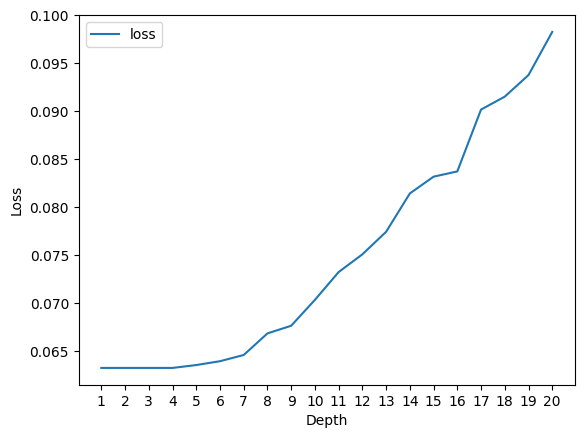

In [ ]:
x = range(1, 21)
plt.plot(x, loss, '-', label="loss")
plt.xticks(ticks=x, labels=x)
plt.xlabel('Depth')
plt.ylabel('Loss')
plt.legend(loc='best')

Training and predicting result

In [60]:
# 依照上述結果在深度超過5後error有明顯上升，因此選擇5為預剪枝決策樹的最大深度
depth = 5
# 訓練剪枝後的決策樹
start = time.time()
prun_tree = dt.fit(df=x_train, max_depth=depth)
prun_pred = dt.make_predictions(x_test, prun_tree)
print("執行時間：%f 秒" % (time.time()-start))
print("準確率：%f" % prun_pred[1])

執行時間：53.997967 秒
準確率：0.910200


Decision tree with pruning by k-fold cross validation

第1.000000次計算
第2.000000次計算
第3.000000次計算
驗證平均誤差：0.063306
運行時間：67.120267 秒


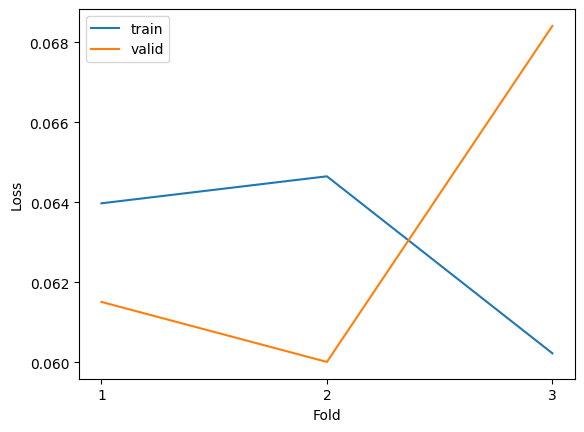

In [61]:
# k = 3
prun_dtcv3 = dt.kfold(max_depth=depth, df=x_train, test=x_test, k=3)
plt.plot(x3, prun_dtcv3[2], '-', label="train")
plt.plot(x3, prun_dtcv3[3], '-', label="valid")
plt.xticks(ticks=x3, labels=x3)
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.legend(loc='best')

第1.000000次計算
第2.000000次計算
第3.000000次計算
第4.000000次計算
第5.000000次計算
驗證平均誤差：0.063600
運行時間：156.545238 秒


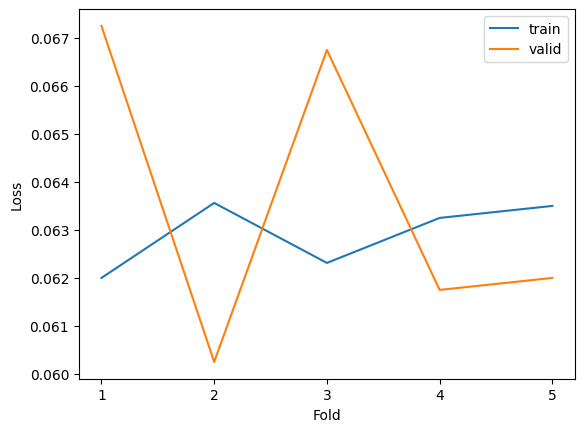

In [62]:
# k = 5
prun_dtcv5 = dt.kfold(max_depth=depth, df=x_train, test=x_test, k=5)
plt.plot(x5, prun_dtcv5[2], '-', label="train")
plt.plot(x5, prun_dtcv5[3], '-', label="valid")
plt.xticks(ticks=x5, labels=x5)
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.legend(loc='best')

第1.000000次計算
第2.000000次計算
第3.000000次計算
第4.000000次計算
第5.000000次計算
第6.000000次計算
第7.000000次計算
第8.000000次計算
第9.000000次計算
第10.000000次計算
驗證平均誤差：0.063500
運行時間：388.341534 秒


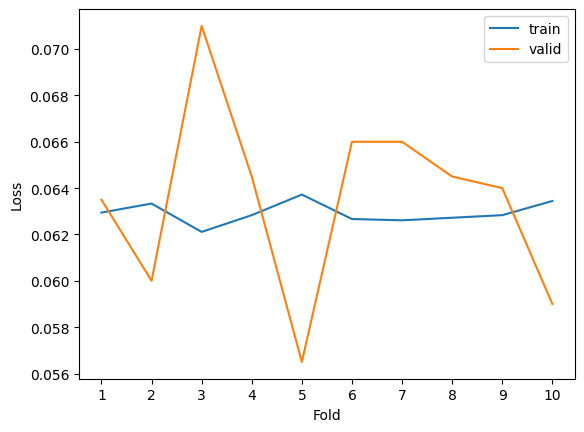

In [64]:
# k = 10
prun_dtcv10 = dt.kfold(max_depth=depth, df=x_train, test=x_test, k=10)
plt.plot(x10, prun_dtcv10[2], '-', label="train")
plt.plot(x10, prun_dtcv10[3], '-', label="valid")
plt.xticks(ticks=x10, labels=x10)
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.legend(loc='best')

Using 5-fold cross validation to Check if new feature set is better than oiginal feature set for decision tree with pruning

In [65]:
new_prun_dtcv5 = dt.kfold(max_depth=depth, df=x_train_new, test=x_test_new, k=5)

第1.000000次計算
第2.000000次計算
第3.000000次計算
第4.000000次計算
第5.000000次計算
驗證平均誤差：0.063900
運行時間：165.067650 秒


In [66]:
# print("總執行時間：%f 秒" % (time.time()-all_start))